In [1]:
## This notebook will be used to determine the extent that out threshold passed GI scores can recall PPI information
## from the STRING dataset

## plots generated using this notebook are used in Figure 2F and 2G

In [3]:
## Import modules

import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
#import networkx as nx
import requests
from scipy.stats import chisquare

In [4]:
## Import data

## Import gene level interaction maps, generated by the "generateGeneMap" function in the 
## "call_genetic_interactions" notebook

dmso1_map = pd.read_excel('/Users/benh/Desktop/GI_data/gene_maps/dmso1_map.xlsx',index_col = 0)
atr_map = pd.read_excel('/Users/benh/Desktop/GI_data/gene_maps/atr_map.xlsx',index_col = 0)
dmso2_map = pd.read_excel('/Users/benh/Desktop/GI_data/gene_maps/dmso2_map.xlsx',index_col = 0)
etop_map = pd.read_excel('/Users/benh/Desktop/GI_data/gene_maps/etop_map.xlsx',index_col = 0)
keto_map = pd.read_excel('/Users/benh/Desktop/GI_data/gene_maps/keto_map.xlsx',index_col = 0)

In [13]:
## Define Functions here

## Import Max's handy upperTriangle function to avoid counting AB BA GIs twice
def upperTriangle(matrix, k=1):
    keep = np.triu(np.ones(matrix.shape), k=k).astype('bool').reshape(matrix.size)
    return matrix.stack(dropna=False,future_stack=True).loc[keep]

## This function will take a gimap, and return a list composed of all unique gene-gene pairs that fall between
## a lower and upper threshold in the format "gene1:gene2"
def int_range(gimap,low_thresh,high_thresh):
    out_list = []
    test = upperTriangle(abs(gimap))
    for i, score in enumerate(test):
        if score > low_thresh:
            if score < high_thresh:
                out_list.append(test.index[i][0]+':'+test.index[i][1])
    return out_list


## all_unique_pair takes a gene list and returns all unique gene pairs in the list in the format "gene1:gene2"
def all_unique_pair(gene_list):
    out_list = []
    for i in range(len(gene_list)):
        for j in range(i+1,len(gene_list)):
            out_list.append(gene_list[i]+':'+gene_list[j])
    return out_list
    
## ppi_scores takes a list of gene pairs in the format "gene1:gene2" and returns the average STRING PPI score for 
## all genes in the list. If a gene pair is not in the STRING database, that score is calculated as 0
def ppi_scores(int_list):
    out_list=[]
    if len(int_list) == 0:
        return 0.0
    for pair in int_list:
        g1,g2 = pair.split(':')
        pair_rev = g2+':'+g1
        if pair in ppi_dict.keys():
            out_list.append(ppi_dict[pair])
        if pair_rev in ppi_dict.keys():
            out_list.append(ppi_dict[pair_rev])
        if pair not in ppi_dict.keys() and pair_rev not in ppi_dict.keys():
            out_list.append(0)
    return np.mean(out_list)

## binary_ppi_ratio takes a list of gene pairs in the format "gene1:gene2" and returns the total number of pairs
## in the list with a >0 STRING PPI score, it also returns that value normalized by the length of the list
def binary_ppi_ratio(int_list):
    ppi_count = 0
    if len(int_list) == 0:
        return 0
    for pair in int_list:
        g1,g2 = pair.split(':')
        pair_rev = g2+':'+g1
        if pair in ppi_dict.keys():
            if ppi_dict[pair] > 0.0:
                ppi_count += 1
        if pair_rev in ppi_dict.keys():
            if ppi_dict[pair_rev] > 0.0:
                ppi_count += 1
    return ppi_count, ppi_count/len(int_list)
   

In [6]:
## Fill nan values in the map with zeros

dmso1_map = dmso1_map.fillna(0)
atr_map = atr_map.fillna(0)
dmso2_map = dmso2_map.fillna(0)
etop_map = etop_map.fillna(0)
keto_map = keto_map.fillna(0)


In [7]:
## Import STRING interactions
## Pipeline used from here https://towardsdatascience.com/visualizing-protein-networks-in-python-58a9b51be9d5

protein_list = list(dmso1_map.index)

proteins = '%0d'.join(protein_list)
url = 'https://string-db.org/api/tsv/network?identifiers=' + proteins + '&species=9606'
r = requests.get(url)
lines = r.text.split('\n') # pull the text from the response object and split based on new lines
data = [l.split('\t') for l in lines] # split each line into its components based on tabs
# convert to dataframe using the first row as the column names; drop empty, final row
df = pd.DataFrame(data[1:-1], columns = data[0]) 
interactions = df[['preferredName_A', 'preferredName_B', 'escore','ascore','dscore']]
interactions.columns = ['geneA','geneB','PPI','coEx','DB']
interactions.index = range(0,len(interactions.index))

In [8]:
## Define and populate a dictionary with keys equal to all STRING gene pairs in the format gene1:gene2 and values
## equal to the STRING PPI score for that gene pair

ppi_dict = dict()
for i in interactions.index:
    ppi_dict[interactions.loc[i,'geneA']+':'+interactions.loc[i,'geneB']] =float(interactions.loc[i,'PPI'])

In [9]:
## Calculate the average STRING PPI score across all gene pairs in our library, for normalization purposes 
all_scores = ppi_scores(all_unique_pair(dmso1_map.index))

In [10]:
## Calculate the total number of gene pairs in our library that have any STRING PPI score 
background = binary_ppi_ratio(all_unique_pair(dmso1_map.index))

/var/folders/wj/l9cwkbvn3f3b12_8zbvnd4500000gp/T/ipykernel_72560/1282297706.py:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  return matrix.stack(dropna=False).loc[keep]
/var/folders/wj/l9cwkbvn3f3b12_8zbvnd4500000gp/T/ipykernel_72560/1282297706.py:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  return matrix.stack(dropna=False).loc[keep]
/var/folders/wj/l9cwkbvn3f3b12_8zbvnd4500000gp/T/ipykernel_72560/1282297706.py:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pand

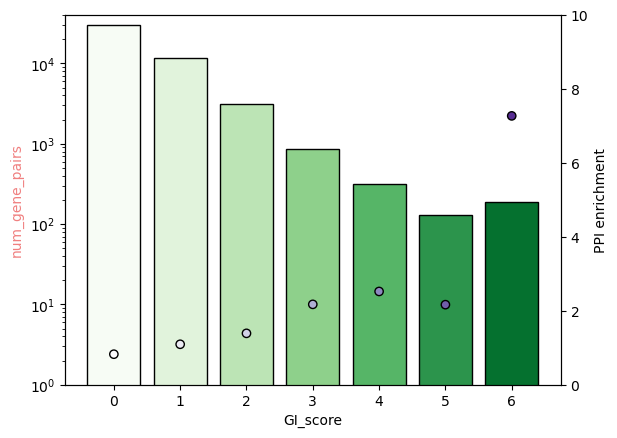

1.980496656534094e-27


In [11]:
## Plot the number of gene pairs in the reference1 map in each bin of absolute GIs from 0 in increments of 1.0 up 
## to a maximum value

## define the number of bins
max_score = 7
num_bins = len(np.arange(0,max_score,1))

## num_pairs is a list of the number of GIs in each bin
num_pairs = []
## scores is a list of the average STRING ppi score for all gene pairs in each bins normalized by the average ppi 
##score for all gene pairs in the map
scores = []
## int_tally is a list of the number of gene pairs in each bin that have any detected STRING ppi score
int_tally = []

## iterate through the bins in absolute GI increments of 1.0 and popluate the lists defined above 
for i in np.arange(1,max_score,1):
    pairs = int_range(dmso1_map,i-1,i)
    num_pairs.append(len(pairs))
    scores.append(ppi_scores(pairs)/all_scores)
    int_tally.append(binary_ppi_ratio(pairs)[0])
    
## For the final bin, we take everything above the next highest bins
pairs = [i1+':'+i2 for i1,i2 in upperTriangle(dmso1_map).loc[upperTriangle(abs(dmso1_map))>max_score-1].index]
num_pairs.append(len(pairs))
scores.append(ppi_scores(pairs)/all_scores)
int_tally.append(binary_ppi_ratio(pairs)[0])

## We now want to make an expected list of the number of STRING interactions in each bin, assuming the null 
## hypothesis
h0_int_tally = []
for i in num_pairs:
    h0_int_tally.append((i/np.sum(num_pairs))*np.sum(int_tally))

    
fig, ax1 = plt.subplots()
cmap = sns.color_palette("Greens", as_cmap=True)
ax1.set_xlabel('GI_score')
ax1.set_ylabel('num_gene_pairs',color = 'lightcoral')
ax1.bar(np.arange(0,max_score,1),num_pairs,width = 0.8,color=cmap(np.arange(0,1,1/num_bins)),edgecolor = 'black')
ax1.tick_params(axis='y')
ax1.set_yscale('log')
ax1.set_ylim(1,40000)
ax2 = ax1.twinx() 

cmap = sns.color_palette("Purples", as_cmap=True)
ax2.set_ylabel('PPI enrichment',color = 'black') 
ax2.scatter(np.arange(0,max_score,1),scores, color=cmap(np.arange(0,1,1/num_bins)),edgecolor='black')
ax2.set_ylim(0,10)
#ax2.set_xticks([0,1,2,3,4,5,6,7])


plt.show()
print(stats.chisquare(int_tally,h0_int_tally)[1])
#fig.savefig('/Users/benh/Desktop/for_figs/dmso1_ppi_recall.png',dpi=300)


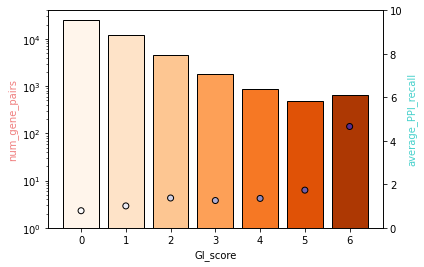

1.9904963806012572e-19


In [10]:
## Plot the number of gene pairs in the reference1 map in each bin of absolute GIs from 0 in increments of 1.0 up 
## to a maximum value

## define the number of bins
max_score = 7
num_bins = len(np.arange(0,max_score,1))

## num_pairs is a list of the number of GIs in each bin
num_pairs = []

## scores is a list of the average STRING ppi score for all gene pairs in each bins normalized by the average ppi 
##score for all gene pairs in the map
scores = []

## int_tally is a list of the number of gene pairs in each bin that have any detected STRING ppi score
int_tally = []

## iterate through the bins in absolute GI increments of 1.0 and popluate the lists defined above 
for i in np.arange(1,max_score,1):
    pairs = int_range(atr_map,i-1,i)
    num_pairs.append(len(pairs))
    scores.append(ppi_scores(pairs)/all_scores)
    int_tally.append(binary_ppi_ratio(pairs)[0])
## For the final bin, we take everything above the next highest bins
pairs = [i1+':'+i2 for i1,i2 in upperTriangle(atr_map).loc[upperTriangle(abs(atr_map))>max_score-1].index]
num_pairs.append(len(pairs))
scores.append(ppi_scores(pairs)/all_scores)
int_tally.append(binary_ppi_ratio(pairs)[0])

## We now want to make an expected list of the number of STRING interactions in each bin, assuming the null 
## hypothesis
h0_int_tally = []
for i in num_pairs:
    h0_int_tally.append((i/np.sum(num_pairs))*np.sum(int_tally))


fig, ax1 = plt.subplots()
cmap = sns.color_palette("Oranges", as_cmap=True)
ax1.set_xlabel('GI_score')
ax1.set_ylabel('num_gene_pairs',color = 'lightcoral')
ax1.bar(np.arange(0,max_score,1),num_pairs,width = 0.8,color=cmap(np.arange(0,1,1/num_bins)),edgecolor='black')
ax1.tick_params(axis='y')
ax1.set_yscale('log')
ax1.set_ylim(1,40000)
ax2 = ax1.twinx() 

cmap = sns.color_palette("Purples", as_cmap=True)
ax2.set_ylabel('average_PPI_recall',color = 'mediumturquoise') 
ax2.scatter(np.arange(0,max_score,1),scores, color=cmap(np.arange(0,1,1/num_bins)),edgecolor='black')
ax2.set_ylim(0,10)


plt.show()
print(stats.chisquare(int_tally,h0_int_tally)[1])
#fig.savefig('/Users/benh/Desktop/for_figs/atr_ppi_recall.png',dpi=300)

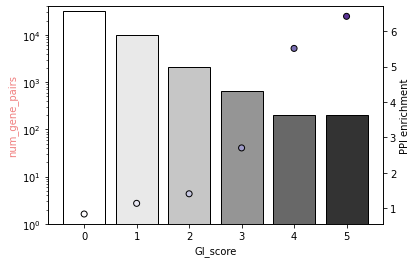

6.393373108551149e-29


In [47]:
## define the number of bins
max_score = 6
num_bins = len(np.arange(0,max_score,1))

## num_pairs is a list of the number of GIs in each bin
num_pairs = []
## scores is a list of the average STRING ppi score for all gene pairs in each bins normalized by the average ppi 
##score for all gene pairs in the map
scores = []
## int_tally is a list of the number of gene pairs in each bin that have any detected STRING ppi score
int_tally = []

## iterate through the bins in absolute GI increments of 1.0 and popluate the lists defined above 
for i in np.arange(1,max_score,1):
    pairs = int_range(dmso2_map,i-1,i)
    num_pairs.append(len(pairs))
    scores.append(ppi_scores(pairs)/all_scores)
    int_tally.append(binary_ppi_ratio(pairs)[0])
    
## For the final bin, we take everything above the next highest bins
pairs = [i1+':'+i2 for i1,i2 in upperTriangle(dmso2_map).loc[upperTriangle(abs(dmso2_map))>max_score-1].index]
num_pairs.append(len(pairs))
scores.append(ppi_scores(pairs)/all_scores)
int_tally.append(binary_ppi_ratio(pairs)[0])

## We now want to make an expected list of the number of STRING interactions in each bin, assuming the null 
## hypothesis
h0_int_tally = []
for i in num_pairs:
    h0_int_tally.append((i/np.sum(num_pairs))*np.sum(int_tally))

    
fig, ax1 = plt.subplots()
cmap = sns.color_palette("Greys", as_cmap=True)
ax1.set_xlabel('GI_score')
ax1.set_ylabel('num_gene_pairs',color = 'lightcoral')
ax1.bar(np.arange(0,max_score,1),num_pairs,width = 0.8,color=cmap(np.arange(0,1,1/num_bins)),edgecolor = 'black')
ax1.tick_params(axis='y')
ax1.set_yscale('log')
ax1.set_ylim(1,40000)
ax2 = ax1.twinx() 

cmap = sns.color_palette("Purples", as_cmap=True)
ax2.set_ylabel('PPI enrichment',color = 'black') 
ax2.scatter(np.arange(0,max_score,1),scores, color=cmap(np.arange(0,1,1/num_bins)),edgecolor='black')
#ax2.set_ylim(0,10)
#ax2.set_xticks([0,1,2,3,4,5,6,7])


plt.show()
print(stats.chisquare(int_tally,h0_int_tally)[1])
#fig.savefig('/Users/benh/Desktop/for_figs/dmso2_ppi_recall.png',dpi=300)

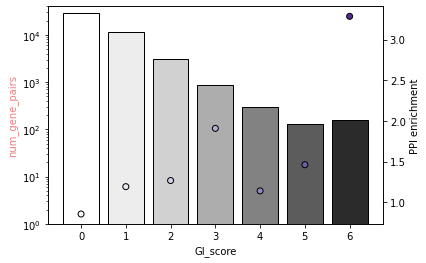

2.0800184486568647e-06


In [46]:

## define the number of bins
max_score = 7
num_bins = len(np.arange(0,max_score,1))

## num_pairs is a list of the number of GIs in each bin
num_pairs = []
## scores is a list of the average STRING ppi score for all gene pairs in each bins normalized by the average ppi 
##score for all gene pairs in the map
scores = []
## int_tally is a list of the number of gene pairs in each bin that have any detected STRING ppi score
int_tally = []

## iterate through the bins in absolute GI increments of 1.0 and popluate the lists defined above 
for i in np.arange(1,max_score,1):
    pairs = int_range(etop_map,i-1,i)
    num_pairs.append(len(pairs))
    scores.append(ppi_scores(pairs)/all_scores)
    int_tally.append(binary_ppi_ratio(pairs)[0])
    
## For the final bin, we take everything above the next highest bins
pairs = [i1+':'+i2 for i1,i2 in upperTriangle(etop_map).loc[upperTriangle(abs(etop_map))>max_score-1].index]
num_pairs.append(len(pairs))
scores.append(ppi_scores(pairs)/all_scores)
int_tally.append(binary_ppi_ratio(pairs)[0])

## We now want to make an expected list of the number of STRING interactions in each bin, assuming the null 
## hypothesis
h0_int_tally = []
for i in num_pairs:
    h0_int_tally.append((i/np.sum(num_pairs))*np.sum(int_tally))

    
fig, ax1 = plt.subplots()
cmap = sns.color_palette("Greys", as_cmap=True)
ax1.set_xlabel('GI_score')
ax1.set_ylabel('num_gene_pairs',color = 'lightcoral')
ax1.bar(np.arange(0,max_score,1),num_pairs,width = 0.8,color=cmap(np.arange(0,1,1/num_bins)),edgecolor = 'black')
ax1.tick_params(axis='y')
ax1.set_yscale('log')
ax1.set_ylim(1,40000)
ax2 = ax1.twinx() 

cmap = sns.color_palette("Purples", as_cmap=True)
ax2.set_ylabel('PPI enrichment',color = 'black') 
ax2.scatter(np.arange(0,max_score,1),scores, color=cmap(np.arange(0,1,1/num_bins)),edgecolor='black')
#ax2.set_ylim(0,10)
#ax2.set_xticks([0,1,2,3,4,5,6,7])


plt.show()
print(stats.chisquare(int_tally,h0_int_tally)[1])
#fig.savefig('/Users/benh/Desktop/for_figs/etop_ppi_recall.png',dpi=300)

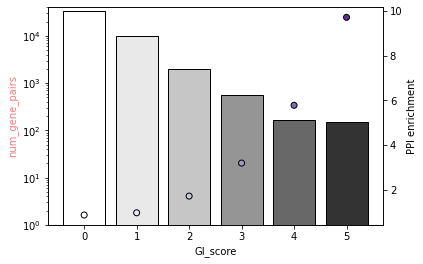

3.0285280474963013e-41


In [42]:

## define the number of bins
max_score = 6
num_bins = len(np.arange(0,max_score,1))

## num_pairs is a list of the number of GIs in each bin
num_pairs = []
## scores is a list of the average STRING ppi score for all gene pairs in each bins normalized by the average ppi 
##score for all gene pairs in the map
scores = []
## int_tally is a list of the number of gene pairs in each bin that have any detected STRING ppi score
int_tally = []

## iterate through the bins in absolute GI increments of 1.0 and popluate the lists defined above 
for i in np.arange(1,max_score,1):
    pairs = int_range(keto_map,i-1,i)
    num_pairs.append(len(pairs))
    scores.append(ppi_scores(pairs)/all_scores)
    int_tally.append(binary_ppi_ratio(pairs)[0])
    
## For the final bin, we take everything above the next highest bins
pairs = [i1+':'+i2 for i1,i2 in upperTriangle(keto_map).loc[upperTriangle(abs(keto_map))>max_score-1].index]
num_pairs.append(len(pairs))
scores.append(ppi_scores(pairs)/all_scores)
int_tally.append(binary_ppi_ratio(pairs)[0])

## We now want to make an expected list of the number of STRING interactions in each bin, assuming the null 
## hypothesis
h0_int_tally = []
for i in num_pairs:
    h0_int_tally.append((i/np.sum(num_pairs))*np.sum(int_tally))

    
fig, ax1 = plt.subplots()
cmap = sns.color_palette("Greys", as_cmap=True)
ax1.set_xlabel('GI_score')
ax1.set_ylabel('num_gene_pairs',color = 'lightcoral')
ax1.bar(np.arange(0,max_score,1),num_pairs,width = 0.8,color=cmap(np.arange(0,1,1/num_bins)),edgecolor = 'black')
ax1.tick_params(axis='y')
ax1.set_yscale('log')
ax1.set_ylim(1,40000)
ax2 = ax1.twinx() 

cmap = sns.color_palette("Purples", as_cmap=True)
ax2.set_ylabel('PPI enrichment',color = 'black') 
ax2.scatter(np.arange(0,max_score,1),scores, color=cmap(np.arange(0,1,1/num_bins)),edgecolor='black')
#ax2.set_ylim(0,10)
#ax2.set_xticks([0,1,2,3,4,5,6,7])


plt.show()
print(stats.chisquare(int_tally,h0_int_tally)[1])
#fig.savefig('/Users/benh/Desktop/for_figs/keto_ppi_recall.png',dpi=300)